In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


0. 필요한 모듈 로드

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
import sys
from scipy import special
import six
import torch
import torch.utils.data
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn import (Dropout, LeakyReLU, Linear, Module, ReLU, Sequential,
Conv2d, ConvTranspose2d, Sigmoid, init, BCELoss, CrossEntropyLoss,SmoothL1Loss,LayerNorm)
from tqdm import tqdm


1. 데이터 전처리 ( 연속형, 혼합형, 범주형 )

In [ ]:
class DataPrep(object):

    def __init__(self, raw_df: pd.DataFrame, categorical: list, log:list, mixed:dict, general:list, non_categorical:list, integer:list, type:dict, test_ratio:float):


        self.categorical_columns = categorical
        self.log_columns = log
        self.mixed_columns = mixed
        self.general_columns = general
        self.non_categorical_columns = non_categorical
        self.integer_columns = integer
        self.column_types = dict()
        self.column_types["categorical"] = []
        self.column_types["mixed"] = {}
        self.column_types["general"] = []
        self.column_types["non_categorical"] = []
        self.lower_bounds = {}
        self.label_encoder_list = []

        problem = list(type.keys())[0]
        target_col = list(type.values())[0]
        if problem:
            y_real = raw_df[target_col]
            X_real = raw_df.drop(columns=[target_col])

            if problem=="Classification":
                X_train_real, _, y_train_real, _ = model_selection.train_test_split(X_real ,y_real, test_size=test_ratio, stratify=y_real,random_state=42)
            else:
                X_train_real, _, y_train_real, _ = model_selection.train_test_split(X_real ,y_real, test_size=test_ratio,random_state=42)

            X_train_real[target_col]= y_train_real

            self.df = X_train_real

        else:
            self.df = raw_df
        self.df = self.df.replace(r' ', np.nan)
        self.df = self.df.fillna('empty')

        all_columns= set(self.df.columns)
        irrelevant_missing_columns = set(self.categorical_columns)
        relevant_missing_columns = list(all_columns - irrelevant_missing_columns)

        for i in relevant_missing_columns:
            if i in self.log_columns:
                if "empty" in list(self.df[i].values):
                    self.df[i] = self.df[i].apply(lambda x: -9999999 if x=="empty" else x)
                    self.mixed_columns[i] = [-9999999]
            elif i in list(self.mixed_columns.keys()):
                if "empty" in list(self.df[i].values):
                    self.df[i] = self.df[i].apply(lambda x: -9999999 if x=="empty" else x )
                    self.mixed_columns[i].append(-9999999)
            else:
                if "empty" in list(self.df[i].values):
                    self.df[i] = self.df[i].apply(lambda x: -9999999 if x=="empty" else x)
                    self.mixed_columns[i] = [-9999999]

        if self.log_columns:
            for log_column in self.log_columns:
                valid_indices = []
                for idx,val in enumerate(self.df[log_column].values):
                    if val!=-9999999:
                        valid_indices.append(idx)
                eps = 1
                lower = np.min(self.df[log_column].iloc[valid_indices].values)
                self.lower_bounds[log_column] = lower
                if lower>0:
                    self.df[log_column] = self.df[log_column].apply(lambda x: np.log(x) if x!=-9999999 else -9999999)
                elif lower == 0:
                    self.df[log_column] = self.df[log_column].apply(lambda x: np.log(x+eps) if x!=-9999999 else -9999999)
                else:
                    self.df[log_column] = self.df[log_column].apply(lambda x: np.log(x-lower+eps) if x!=-9999999 else -9999999)

        for column_index, column in enumerate(self.df.columns):
            if column in self.categorical_columns:
                label_encoder = preprocessing.LabelEncoder()
                self.df[column] = self.df[column].astype(str)
                label_encoder.fit(self.df[column])
                current_label_encoder = dict()
                current_label_encoder['column'] = column
                current_label_encoder['label_encoder'] = label_encoder
                transformed_column = label_encoder.transform(self.df[column])
                self.df[column] = transformed_column
                self.label_encoder_list.append(current_label_encoder)
                self.column_types["categorical"].append(column_index)

                if column in self.general_columns:
                    self.column_types["general"].append(column_index)

                if column in self.non_categorical_columns:
                    self.column_types["non_categorical"].append(column_index)

            elif column in self.mixed_columns:
                self.column_types["mixed"][column_index] = self.mixed_columns[column]

            elif column in self.general_columns:
                self.column_types["general"].append(column_index)


        super().__init__()

    def inverse_prep(self, data, eps=1):

        df_sample = pd.DataFrame(data,columns=self.df.columns)

        for i in range(len(self.label_encoder_list)):
            le = self.label_encoder_list[i]["label_encoder"]
            df_sample[self.label_encoder_list[i]["column"]] = df_sample[self.label_encoder_list[i]["column"]].astype(int)
            df_sample[self.label_encoder_list[i]["column"]] = le.inverse_transform(df_sample[self.label_encoder_list[i]["column"]])

        if self.log_columns:
            for i in df_sample:
                if i in self.log_columns:
                    lower_bound = self.lower_bounds[i]
                    if lower_bound>0:
                        df_sample[i].apply(lambda x: np.exp(x))
                    elif lower_bound==0:
                        df_sample[i] = df_sample[i].apply(lambda x: np.ceil(np.exp(x)-eps) if (np.exp(x)-eps) < 0 else (np.exp(x)-eps))
                    else:
                        df_sample[i] = df_sample[i].apply(lambda x: np.exp(x)-eps+lower_bound)

        if self.integer_columns:
            for column in self.integer_columns:
                df_sample[column]= (np.round(df_sample[column].values))
                df_sample[column] = df_sample[column].astype(int)

        df_sample.replace(-9999999, np.nan,inplace=True)
        df_sample.replace('empty', np.nan,inplace=True)

        return df_sample

2. Differential Privacy, DP , RDP 에 관한 함수

In [ ]:
def _log_add(logx, logy):
  """Add two numbers in the log space."""
  a, b = min(logx, logy), max(logx, logy)
  if a == -np.inf:  # adding 0
    return b
  # Use exp(a) + exp(b) = (exp(a - b) + 1) * exp(b)
  return math.log1p(math.exp(a - b)) + b  # log1p(x) = log(x + 1)


def _log_sub(logx, logy):
  """Subtract two numbers in the log space. Answer must be non-negative."""
  if logx < logy:
    raise ValueError("The result of subtraction must be non-negative.")
  if logy == -np.inf:  # subtracting 0
    return logx
  if logx == logy:
    return -np.inf  # 0 is represented as -np.inf in the log space.

  try:
    # Use exp(x) - exp(y) = (exp(x - y) - 1) * exp(y).
    return math.log(math.expm1(logx - logy)) + logy  # expm1(x) = exp(x) - 1
  except OverflowError:
    return logx


def _log_print(logx):
  """Pretty print."""
  if logx < math.log(sys.float_info.max):
    return "{}".format(math.exp(logx))
  else:
    return "exp({})".format(logx)


def _compute_log_a_int(q, sigma, alpha):
  """Compute log(A_alpha) for integer alpha. 0 < q < 1."""
  assert isinstance(alpha, six.integer_types)

  # Initialize with 0 in the log space.
  log_a = -np.inf

  for i in range(alpha + 1):
    log_coef_i = (
        math.log(special.binom(alpha, i)) + i * math.log(q) +
        (alpha - i) * math.log(1 - q))

    s = log_coef_i + (i * i - i) / (2 * (sigma**2))
    log_a = _log_add(log_a, s)

  return float(log_a)


def _compute_log_a_frac(q, sigma, alpha):
  """Compute log(A_alpha) for fractional alpha. 0 < q < 1."""
  # The two parts of A_alpha, integrals over (-inf,z0] and [z0, +inf), are
  # initialized to 0 in the log space:
  log_a0, log_a1 = -np.inf, -np.inf
  i = 0

  z0 = sigma**2 * math.log(1 / q - 1) + .5

  while True:  # do ... until loop
    coef = special.binom(alpha, i)
    log_coef = math.log(abs(coef))
    j = alpha - i

    log_t0 = log_coef + i * math.log(q) + j * math.log(1 - q)
    log_t1 = log_coef + j * math.log(q) + i * math.log(1 - q)

    log_e0 = math.log(.5) + _log_erfc((i - z0) / (math.sqrt(2) * sigma))
    log_e1 = math.log(.5) + _log_erfc((z0 - j) / (math.sqrt(2) * sigma))

    log_s0 = log_t0 + (i * i - i) / (2 * (sigma**2)) + log_e0
    log_s1 = log_t1 + (j * j - j) / (2 * (sigma**2)) + log_e1

    if coef > 0:
      log_a0 = _log_add(log_a0, log_s0)
      log_a1 = _log_add(log_a1, log_s1)
    else:
      log_a0 = _log_sub(log_a0, log_s0)
      log_a1 = _log_sub(log_a1, log_s1)

    i += 1
    if max(log_s0, log_s1) < -30:
      break

  return _log_add(log_a0, log_a1)


def _compute_log_a(q, sigma, alpha):
  """Compute log(A_alpha) for any positive finite alpha."""
  if float(alpha).is_integer():
    return _compute_log_a_int(q, sigma, int(alpha))
  else:
    return _compute_log_a_frac(q, sigma, alpha)


def _log_erfc(x):
  """Compute log(erfc(x)) with high accuracy for large x."""
  try:
    return math.log(2) + special.log_ndtr(-x * 2**.5)
  except NameError:
    # If log_ndtr is not available, approximate as follows:
    r = special.erfc(x)
    if r == 0.0:
      # Using the Laurent series at infinity for the tail of the erfc function:
      #     erfc(x) ~ exp(-x^2-.5/x^2+.625/x^4)/(x*pi^.5)
      # To verify in Mathematica:
      #     Series[Log[Erfc[x]] + Log[x] + Log[Pi]/2 + x^2, {x, Infinity, 6}]
      return (-math.log(math.pi) / 2 - math.log(x) - x**2 - .5 * x**-2 +
              .625 * x**-4 - 37. / 24. * x**-6 + 353. / 64. * x**-8)
    else:
      return math.log(r)


def _compute_delta(orders, rdp, eps):
  """Compute delta given a list of RDP values and target epsilon.

  Args:
    orders: An array (or a scalar) of orders.
    rdp: A list (or a scalar) of RDP guarantees.
    eps: The target epsilon.

  Returns:
    Pair of (delta, optimal_order).

  Raises:
    ValueError: If input is malformed.

  """
  orders_vec = np.atleast_1d(orders)
  rdp_vec = np.atleast_1d(rdp)

  if len(orders_vec) != len(rdp_vec):
    raise ValueError("Input lists must have the same length.")

  deltas = np.exp((rdp_vec - eps) * (orders_vec - 1))
  idx_opt = np.argmin(deltas)
  return min(deltas[idx_opt], 1.), orders_vec[idx_opt]


def _compute_eps(orders, rdp, delta):
  """Compute epsilon given a list of RDP values and target delta.

  Args:
    orders: An array (or a scalar) of orders.
    rdp: A list (or a scalar) of RDP guarantees.
    delta: The target delta.

  Returns:
    Pair of (eps, optimal_order).

  Raises:
    ValueError: If input is malformed.

  """
  orders_vec = np.atleast_1d(orders)
  rdp_vec = np.atleast_1d(rdp)

  if len(orders_vec) != len(rdp_vec):
    raise ValueError("Input lists must have the same length.")

  eps = rdp_vec - math.log(delta) / (orders_vec - 1)

  idx_opt = np.nanargmin(eps)  # Ignore NaNs
  return eps[idx_opt], orders_vec[idx_opt]


def _compute_rdp(q, sigma, alpha):
  """Compute RDP of the Sampled Gaussian mechanism at order alpha.

  Args:
    q: The sampling rate.
    sigma: The std of the additive Gaussian noise.
    alpha: The order at which RDP is computed.

  Returns:
    RDP at alpha, can be np.inf.
  """
  if q == 0:
    return 0

  if q == 1.:
    return alpha / (2 * sigma**2)

  if np.isinf(alpha):
    return np.inf

  return _compute_log_a(q, sigma, alpha) / (alpha - 1)


def compute_rdp(q, noise_multiplier, steps, orders):
  """Compute RDP of the Sampled Gaussian Mechanism.

  Args:
    q: The sampling rate.
    noise_multiplier: The ratio of the standard deviation of the Gaussian noise
        to the l2-sensitivity of the function to which it is added.
    steps: The number of steps.
    orders: An array (or a scalar) of RDP orders.

  Returns:
    The RDPs at all orders, can be np.inf.
  """
  if np.isscalar(orders):
    rdp = _compute_rdp(q, noise_multiplier, orders)
  else:
    rdp = np.array([_compute_rdp(q, noise_multiplier, order)
                    for order in orders])

  return rdp * steps


def get_privacy_spent(orders, rdp, target_eps=None, target_delta=None):
  """Compute delta (or eps) for given eps (or delta) from RDP values.

  Args:
    orders: An array (or a scalar) of RDP orders.
    rdp: An array of RDP values. Must be of the same length as the orders list.
    target_eps: If not None, the epsilon for which we compute the corresponding
              delta.
    target_delta: If not None, the delta for which we compute the corresponding
              epsilon. Exactly one of target_eps and target_delta must be None.

  Returns:
    eps, delta, opt_order.

  Raises:
    ValueError: If target_eps and target_delta are messed up.
  """
  if target_eps is None and target_delta is None:
    raise ValueError(
        "Exactly one out of eps and delta must be None. (Both are).")

  if target_eps is not None and target_delta is not None:
    raise ValueError(
        "Exactly one out of eps and delta must be None. (None is).")

  if target_eps is not None:
    delta, opt_order = _compute_delta(orders, rdp, target_eps)
    return target_eps, delta, opt_order
  else:
    eps, opt_order = _compute_eps(orders, rdp, target_delta)
    return eps, target_delta, opt_order


def compute_rdp_from_ledger(ledger, orders):
  """Compute RDP of Sampled Gaussian Mechanism from ledger.

  Args:
    ledger: A formatted privacy ledger.
    orders: An array (or a scalar) of RDP orders.

  Returns:
    RDP at all orders, can be np.inf.
  """
  total_rdp = np.zeros_like(orders, dtype=float)
  for sample in ledger:
    # Compute equivalent z from l2_clip_bounds and noise stddevs in sample.
    # See https://arxiv.org/pdf/1812.06210.pdf for derivation of this formula.
    effective_z = sum([
        (q.noise_stddev / q.l2_norm_bound)**-2 for q in sample.queries])**-0.5
    total_rdp += compute_rdp(
        sample.selection_probability, effective_z, 1, orders)
  return total_rdp

3. CTAB-GAN+ 구현 , sampling

In [ ]:
class Classifier(Module):
    def __init__(self,input_dim, dis_dims,st_ed):
        super(Classifier,self).__init__()
        dim = input_dim-(st_ed[1]-st_ed[0])
        seq = []
        self.str_end = st_ed
        for item in list(dis_dims):
            seq += [
                Linear(dim, item),
                LeakyReLU(0.2),
                Dropout(0.5)
            ]
            dim = item

        if (st_ed[1]-st_ed[0])==1:
            seq += [Linear(dim, 1)]

        elif (st_ed[1]-st_ed[0])==2:
            seq += [Linear(dim, 1),Sigmoid()]
        else:
            seq += [Linear(dim,(st_ed[1]-st_ed[0]))]

        self.seq = Sequential(*seq)

    def forward(self, input):

        label=None

        if (self.str_end[1]-self.str_end[0])==1:
            label = input[:, self.str_end[0]:self.str_end[1]]
        else:
            label = torch.argmax(input[:, self.str_end[0]:self.str_end[1]], axis=-1)

        new_imp = torch.cat((input[:,:self.str_end[0]],input[:,self.str_end[1]:]),1)

        if ((self.str_end[1]-self.str_end[0])==2) | ((self.str_end[1]-self.str_end[0])==1):
            return self.seq(new_imp).view(-1), label
        else:
            return self.seq(new_imp), label

def apply_activate(data, output_info):
    data_t = []
    st = 0
    for item in output_info:
        if item[1] == 'tanh':
            ed = st + item[0]
            data_t.append(torch.tanh(data[:, st:ed]))
            st = ed
        elif item[1] == 'softmax':
            ed = st + item[0]
            data_t.append(F.gumbel_softmax(data[:, st:ed], tau=0.2))
            st = ed
    return torch.cat(data_t, dim=1)

def get_st_ed(target_col_index,output_info):
    st = 0
    c= 0
    tc= 0

    for item in output_info:
        if c==target_col_index:
            break
        if item[1]=='tanh':
            st += item[0]
            if item[2] == 'yes_g':
                c+=1
        elif item[1] == 'softmax':
            st += item[0]
            c+=1
        tc+=1

    ed= st+output_info[tc][0]

    return (st,ed)

def random_choice_prob_index_sampling(probs,col_idx):
    option_list = []
    for i in col_idx:
        pp = probs[i]
        option_list.append(np.random.choice(np.arange(len(probs[i])), p=pp))

    return np.array(option_list).reshape(col_idx.shape)

def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1 - axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

def maximum_interval(output_info):
    max_interval = 0
    for item in output_info:
        max_interval = max(max_interval, item[0])
    return max_interval

class Cond(object):
    def __init__(self, data, output_info):

        self.model = []
        st = 0
        counter = 0
        for item in output_info:

            if item[1] == 'tanh':
                st += item[0]
                continue
            elif item[1] == 'softmax':
                ed = st + item[0]
                counter += 1
                self.model.append(np.argmax(data[:, st:ed], axis=-1))
                st = ed

        self.interval = []
        self.n_col = 0
        self.n_opt = 0
        st = 0
        self.p = np.zeros((counter, maximum_interval(output_info)))
        self.p_sampling = []
        for item in output_info:
            if item[1] == 'tanh':
                st += item[0]
                continue
            elif item[1] == 'softmax':
                ed = st + item[0]
                tmp = np.sum(data[:, st:ed], axis=0)
                tmp_sampling = np.sum(data[:, st:ed], axis=0)
                tmp = np.log(tmp + 1)
                tmp = tmp / np.sum(tmp)
                tmp_sampling = tmp_sampling / np.sum(tmp_sampling)
                self.p_sampling.append(tmp_sampling)
                self.p[self.n_col, :item[0]] = tmp
                self.interval.append((self.n_opt, item[0]))
                self.n_opt += item[0]
                self.n_col += 1
                st = ed

        self.interval = np.asarray(self.interval)

    def sample_train(self, batch):
        if self.n_col == 0:
            return None
        batch = batch

        idx = np.random.choice(np.arange(self.n_col), batch)

        vec = np.zeros((batch, self.n_opt), dtype='float32')
        mask = np.zeros((batch, self.n_col), dtype='float32')
        mask[np.arange(batch), idx] = 1
        opt1prime = random_choice_prob_index(self.p[idx])
        for i in np.arange(batch):
            vec[i, self.interval[idx[i], 0] + opt1prime[i]] = 1

        return vec, mask, idx, opt1prime

    def sample(self, batch):
        if self.n_col == 0:
            return None
        batch = batch

        idx = np.random.choice(np.arange(self.n_col), batch)

        vec = np.zeros((batch, self.n_opt), dtype='float32')
        opt1prime = random_choice_prob_index_sampling(self.p_sampling,idx)

        for i in np.arange(batch):
            vec[i, self.interval[idx[i], 0] + opt1prime[i]] = 1

        return vec

def cond_loss(data, output_info, c, m):
    loss = []
    st = 0
    st_c = 0
    for item in output_info:
        if item[1] == 'tanh':
            st += item[0]
            continue

        elif item[1] == 'softmax':
            ed = st + item[0]
            ed_c = st_c + item[0]
            tmp = F.cross_entropy(
            data[:, st:ed],
            torch.argmax(c[:, st_c:ed_c], dim=1),
            reduction='none')
            loss.append(tmp)
            st = ed
            st_c = ed_c

    loss = torch.stack(loss, dim=1)
    return (loss * m).sum() / data.size()[0]

class Sampler(object):
    def __init__(self, data, output_info):
        super(Sampler, self).__init__()
        self.data = data
        self.model = []
        self.n = len(data)
        st = 0
        for item in output_info:
            if item[1] == 'tanh':
                st += item[0]
                continue
            elif item[1] == 'softmax':
                ed = st + item[0]
                tmp = []
                for j in range(item[0]):
                    tmp.append(np.nonzero(data[:, st + j])[0])
                self.model.append(tmp)
                st = ed

    def sample(self, n, col, opt):
        if col is None:
            idx = np.random.choice(np.arange(self.n), n)
            return self.data[idx]
        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self.model[c][o]))
        return self.data[idx]

class Discriminator(Module):
    def __init__(self, side, layers):
        super(Discriminator, self).__init__()
        self.side = side
        info = len(layers)-2
        self.seq = Sequential(*layers)
        self.seq_info = Sequential(*layers[:info])

    def forward(self, input):
        return (self.seq(input)), self.seq_info(input)

class Generator(Module):
    def __init__(self, side, layers):
        super(Generator, self).__init__()
        self.side = side
        self.seq = Sequential(*layers)

    def forward(self, input_):
        return self.seq(input_)

def determine_layers_disc(side, num_channels):
    assert side >= 4 and side <= 64

    layer_dims = [(1, side), (num_channels, side // 2)]

    while layer_dims[-1][1] > 3 and len(layer_dims) < 4:
        layer_dims.append((layer_dims[-1][0] * 2, layer_dims[-1][1] // 2))

    layerNorms = []
    num_c = num_channels
    num_s = side / 2
    for l in range(len(layer_dims) - 1):
        layerNorms.append([int(num_c), int(num_s), int(num_s)])
        num_c = num_c * 2
        num_s = num_s / 2

    layers_D = []

    for prev, curr, ln in zip(layer_dims, layer_dims[1:], layerNorms):
        layers_D += [
            Conv2d(prev[0], curr[0], 4, 2, 1, bias=False),
            LayerNorm(ln),
            LeakyReLU(0.2, inplace=True),
        ]

    layers_D += [Conv2d(layer_dims[-1][0], 1, layer_dims[-1][1], 1, 0), ReLU(True)]

    return layers_D

def determine_layers_gen(side, random_dim, num_channels):
    assert side >= 4 and side <= 64

    layer_dims = [(1, side), (num_channels, side // 2)]

    while layer_dims[-1][1] > 3 and len(layer_dims) < 4:
        layer_dims.append((layer_dims[-1][0] * 2, layer_dims[-1][1] // 2))

    layerNorms = []

    num_c = num_channels * (2 ** (len(layer_dims) - 2))
    num_s = int(side / (2 ** (len(layer_dims) - 1)))
    for l in range(len(layer_dims) - 1):
        layerNorms.append([int(num_c), int(num_s), int(num_s)])
        num_c = num_c / 2
        num_s = num_s * 2

    layers_G = [ConvTranspose2d(random_dim, layer_dims[-1][0], layer_dims[-1][1], 1, 0, output_padding=0, bias=False)]

    for prev, curr, ln in zip(reversed(layer_dims), reversed(layer_dims[:-1]), layerNorms):
        layers_G += [LayerNorm(ln), ReLU(True), ConvTranspose2d(prev[0], curr[0], 4, 2, 1, output_padding=0, bias=True)]
    return layers_G

def slerp(val, low, high):
    low_norm = low/torch.norm(low, dim=1, keepdim=True)
    high_norm = high/torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm*high_norm).sum(1)).view(val.size(0), 1)
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so)*low + (torch.sin(val*omega)/so) * high

    return res

def calc_gradient_penalty_slerp(netD, real_data, fake_data, transformer, device='cpu', lambda_=10):
    batchsize = real_data.shape[0]
    alpha = torch.rand(batchsize, 1,  device=device)
    interpolates = slerp(alpha, real_data, fake_data)
    interpolates = interpolates.to(device)
    interpolates = transformer.transform(interpolates)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates,_ = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradients_norm - 1) ** 2).mean() * lambda_

    return gradient_penalty

def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0)

class CTABGANSynthesizer:
    def __init__(self,
                 class_dim=(256, 256, 256, 256),
                 random_dim=100,
                 num_channels=64,
                 l2scale=1e-5,
                 batch_size=500,
                 epochs=150):


        self.random_dim = random_dim
        self.class_dim = class_dim
        self.num_channels = num_channels
        self.dside = None
        self.gside = None
        self.l2scale = l2scale
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, train_data=pd.DataFrame, categorical=[], mixed={}, general=[], non_categorical=[], type={}):

        problem_type = None
        target_index=None
        if type:
            problem_type = list(type.keys())[0]
            if problem_type:
                target_index = train_data.columns.get_loc(type[problem_type])

        self.transformer = DataTransformer(train_data=train_data, categorical_list=categorical, mixed_dict=mixed, general_list=general, non_categorical_list=non_categorical)
        self.transformer.fit()
        train_data = self.transformer.transform(train_data.values)
        data_sampler = Sampler(train_data, self.transformer.output_info)
        data_dim = self.transformer.output_dim
        self.cond_generator = Cond(train_data, self.transformer.output_info)

        sides = [4, 8, 16, 24, 32, 64]
        col_size_d = data_dim + self.cond_generator.n_opt
        for i in sides:
            if i * i >= col_size_d:
                self.dside = i
                break

        sides = [4, 8, 16, 24, 32, 64]
        col_size_g = data_dim
        for i in sides:
            if i * i >= col_size_g:
                self.gside = i
                break


        layers_G = determine_layers_gen(self.gside, self.random_dim+self.cond_generator.n_opt, self.num_channels) # Generator layer 정의
        layers_D = determine_layers_disc(self.dside, self.num_channels) # Discriminator layer 정의

        self.generator = Generator(self.gside, layers_G).to(self.device) # Generator 정의
        discriminator = Discriminator(self.dside, layers_D).to(self.device) # Discriminator 정의
        optimizer_params = dict(lr=2e-4, betas=(0.5, 0.9), eps=1e-3, weight_decay=self.l2scale)
        optimizerG = Adam(self.generator.parameters(), **optimizer_params) # Generator optimizer 정의
        optimizerD = Adam(discriminator.parameters(), **optimizer_params) # Discriminator optimizer 정의

        st_ed = None
        classifier=None
        optimizerC= None
        if target_index != None:
            st_ed= get_st_ed(target_index,self.transformer.output_info)
            classifier = Classifier(data_dim,self.class_dim,st_ed).to(self.device)
            optimizerC = optim.Adam(classifier.parameters(),**optimizer_params)

        # 가중치 초기화
        self.generator.apply(weights_init)
        discriminator.apply(weights_init)
        # CNN 이기 때문에 이미지 형식으로 바꾸기
        self.Gtransformer = ImageTransformer(self.gside)
        self.Dtransformer = ImageTransformer(self.dside)

        epsilon = 0
        epoch = 0
        steps = 0
        ci = 5

        steps_per_epoch = max(1, len(train_data) // self.batch_size)
        for i in tqdm(range(self.epochs)):
            for id_ in range(steps_per_epoch):


                for _ in range(ci):
                    noisez = torch.randn(self.batch_size, self.random_dim, device=self.device) #noise vector
                    condvec = self.cond_generator.sample_train(self.batch_size) # conditional vector

                    c, m, col, opt = condvec
                    c = torch.from_numpy(c).to(self.device)
                    m = torch.from_numpy(m).to(self.device)
                    noisez = torch.cat([noisez, c], dim=1)#noise+conditional vector
                    noisez =  noisez.view(self.batch_size,self.random_dim+self.cond_generator.n_opt,1,1)

                    perm = np.arange(self.batch_size) #데이터의 순서를 random하게 섞기위한 index 배열을 생성
                    np.random.shuffle(perm)
                    real = data_sampler.sample(self.batch_size, col[perm], opt[perm])
                    c_perm = c[perm]

                    real = torch.from_numpy(real.astype('float32')).to(self.device) # 실제데이터 sampling

                    fake = self.generator(noisez) # 가짜데이터 생성
                    faket = self.Gtransformer.inverse_transform(fake)
                    fakeact = apply_activate(faket, self.transformer.output_info)

                    fake_cat = torch.cat([fakeact, c], dim=1) # 가짜 데이터와 조건부 벡터
                    real_cat = torch.cat([real, c_perm], dim=1) # 실제 데이터와 조건부 벡터

                    real_cat_d = self.Dtransformer.transform(real_cat) # 이미지 형식으로 변환
                    fake_cat_d = self.Dtransformer.transform(fake_cat) # 이미지 형식으로 변환

                    optimizerD.zero_grad()

                    d_real,_ = discriminator(real_cat_d)


                    d_real = -torch.mean(d_real)
                    d_real.backward()


                    d_fake,_ = discriminator(fake_cat_d)

                    d_fake = torch.mean(d_fake)

                    d_fake.backward()

                    pen = calc_gradient_penalty_slerp(discriminator, real_cat, fake_cat,  self.Dtransformer , self.device) # gradient penalty 계산

                    pen.backward()

                    optimizerD.step() # Discriminator 파라미터 업데이트

                noisez = torch.randn(self.batch_size, self.random_dim, device=self.device)

                condvec = self.cond_generator.sample_train(self.batch_size)

                c, m, col, opt = condvec
                c = torch.from_numpy(c).to(self.device)
                m = torch.from_numpy(m).to(self.device)
                noisez = torch.cat([noisez, c], dim=1)
                noisez =  noisez.view(self.batch_size,self.random_dim+self.cond_generator.n_opt,1,1)

                optimizerG.zero_grad()

                fake = self.generator(noisez)
                faket = self.Gtransformer.inverse_transform(fake)
                fakeact = apply_activate(faket, self.transformer.output_info)

                fake_cat = torch.cat([fakeact, c], dim=1)
                fake_cat = self.Dtransformer.transform(fake_cat)

                y_fake,info_fake = discriminator(fake_cat)

                cross_entropy = cond_loss(faket, self.transformer.output_info, c, m)

                _,info_real = discriminator(real_cat_d)


                g = -torch.mean(y_fake) + cross_entropy
                g.backward(retain_graph=True)
                loss_mean = torch.norm(torch.mean(info_fake.view(self.batch_size,-1), dim=0) - torch.mean(info_real.view(self.batch_size,-1), dim=0), 1)
                loss_std = torch.norm(torch.std(info_fake.view(self.batch_size,-1), dim=0) - torch.std(info_real.view(self.batch_size,-1), dim=0), 1)
                loss_info = loss_mean + loss_std
                loss_info.backward()
                optimizerG.step()


                if problem_type:

                    fake = self.generator(noisez)

                    faket = self.Gtransformer.inverse_transform(fake)

                    fakeact = apply_activate(faket, self.transformer.output_info)

                    real_pre, real_label = classifier(real)
                    fake_pre, fake_label = classifier(fakeact)

                    c_loss = CrossEntropyLoss()

                    if (st_ed[1] - st_ed[0])==1:
                        c_loss= SmoothL1Loss()
                        real_label = real_label.type_as(real_pre)
                        fake_label = fake_label.type_as(fake_pre)
                        real_label = torch.reshape(real_label,real_pre.size())
                        fake_label = torch.reshape(fake_label,fake_pre.size())


                    elif (st_ed[1] - st_ed[0])==2:
                        c_loss = BCELoss()
                        real_label = real_label.type_as(real_pre)
                        fake_label = fake_label.type_as(fake_pre)

                    loss_cc = c_loss(real_pre, real_label)
                    loss_cg = c_loss(fake_pre, fake_label)

                    optimizerG.zero_grad()
                    loss_cg.backward()
                    optimizerG.step()

                    optimizerC.zero_grad()
                    loss_cc.backward()
                    optimizerC.step()

            epoch += 1



    def sample(self, n):

        self.generator.eval()

        output_info = self.transformer.output_info
        steps = n // self.batch_size + 1

        data = []

        for i in range(steps):
            noisez = torch.randn(self.batch_size, self.random_dim, device=self.device)
            condvec = self.cond_generator.sample(self.batch_size)
            c = condvec
            c = torch.from_numpy(c).to(self.device)
            noisez = torch.cat([noisez, c], dim=1)
            noisez =  noisez.view(self.batch_size,self.random_dim+self.cond_generator.n_opt,1,1)

            fake = self.generator(noisez)
            faket = self.Gtransformer.inverse_transform(fake)
            fakeact = apply_activate(faket,output_info)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        result,resample = self.transformer.inverse_transform(data)

        while len(result) < n:
            data_resample = []
            steps_left = resample// self.batch_size + 1

            for i in range(steps_left):
                noisez = torch.randn(self.batch_size, self.random_dim, device=self.device)
                condvec = self.cond_generator.sample(self.batch_size)
                c = condvec
                c = torch.from_numpy(c).to(self.device)
                noisez = torch.cat([noisez, c], dim=1)
                noisez =  noisez.view(self.batch_size,self.random_dim+self.cond_generator.n_opt,1,1)

                fake = self.generator(noisez)
                faket = self.Gtransformer.inverse_transform(fake)
                fakeact = apply_activate(faket, output_info)
                data_resample.append(fakeact.detach().cpu().numpy())

            data_resample = np.concatenate(data_resample, axis=0)

            res,resample = self.transformer.inverse_transform(data_resample)
            result  = np.concatenate([result,res],axis=0)

        return result[0:n]

4. CTAB-GAN+에 넣을 수 있도록 DataTransform

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.mixture import BayesianGaussianMixture

class DataTransformer():

    def __init__(self, train_data=pd.DataFrame, categorical_list=[], mixed_dict={}, general_list=[], non_categorical_list=[], n_clusters=10, eps=0.005):
        self.meta = None
        self.n_clusters = n_clusters
        self.eps = eps
        self.train_data = train_data
        self.categorical_columns= categorical_list
        self.mixed_columns= mixed_dict
        self.general_columns = general_list
        self.non_categorical_columns= non_categorical_list

    def get_metadata(self):

        meta = []

        for index in range(self.train_data.shape[1]):
            column = self.train_data.iloc[:,index]
            if index in self.categorical_columns: # 범주형 데이터
                if index in self.non_categorical_columns:
                    meta.append({
                      "name": index,
                      "type": "continuous",
                      "min": column.min(),
                      "max": column.max(),
                    })
                else:
                    mapper = column.value_counts().index.tolist()
                    meta.append({
                        "name": index,
                        "type": "categorical",
                        "size": len(mapper),
                        "i2s": mapper
                    })

            elif index in self.mixed_columns.keys(): # 혼합형 데이터 해당 열의 최댓값, 최솟값 저장
                meta.append({
                    "name": index,
                    "type": "mixed",
                    "min": column.min(),
                    "max": column.max(),
                    "modal": self.mixed_columns[index]
                })
            else: #연속형 데이터 해댱 열의 최댓값, 최솟값 저장
                meta.append({
                    "name": index,
                    "type": "continuous",
                    "min": column.min(),
                    "max": column.max(),
                })

        return meta

    def fit(self):
        data = self.train_data.values
        self.meta = self.get_metadata()
        model = []
        self.ordering = []
        self.output_info = []
        self.output_dim = 0
        self.components = []
        self.filter_arr = []
        for id_, info in enumerate(self.meta):
            if info['type'] == "continuous": # 연속형인 경우
                if id_ not in self.general_columns:
                  gm = BayesianGaussianMixture( #GaussainMixtureMdoel 학습
                      n_components = self.n_clusters,
                      weight_concentration_prior_type='dirichlet_process',
                      weight_concentration_prior=0.001,
                      max_iter=100,n_init=1, random_state=42)
                  gm.fit(data[:, id_].reshape([-1, 1])) #각 Gaussian의 평균과 분산 학습
                  mode_freq = (pd.Series(gm.predict(data[:, id_].reshape([-1, 1]))).value_counts().keys()) # 데이터가 속하는 Gaussian Cluster 예측
                  model.append(gm)
                  old_comp = gm.weights_ > self.eps
                  comp = []
                  for i in range(self.n_clusters):
                      if (i in (mode_freq)) & old_comp[i]:
                          comp.append(True)
                      else:
                          comp.append(False)
                  self.components.append(comp)
                  self.output_info += [(1, 'tanh','no_g'), (np.sum(comp), 'softmax')]
                  self.output_dim += 1 + np.sum(comp)
                else:
                  model.append(None)
                  self.components.append(None)
                  self.output_info += [(1, 'tanh','yes_g')]
                  self.output_dim += 1

            elif info['type'] == "mixed": # 혼합형인 경우

                gm1 = BayesianGaussianMixture( #범주형 + 연속형 전체 분포 확인
                    n_components = self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001, max_iter=100,
                    n_init=1,random_state=42)
                gm2 = BayesianGaussianMixture( # 연속형
                    n_components = self.n_clusters,
                    weight_concentration_prior_type='dirichlet_process',
                    weight_concentration_prior=0.001, max_iter=100,
                    n_init=1,random_state=42)

                gm1.fit(data[:, id_].reshape([-1, 1]))

                filter_arr = []
                for element in data[:, id_]:
                    if element not in info['modal']:
                        filter_arr.append(True)
                    else:
                        filter_arr.append(False)

                gm2.fit(data[:, id_][filter_arr].reshape([-1, 1]))
                mode_freq = (pd.Series(gm2.predict(data[:, id_][filter_arr].reshape([-1, 1]))).value_counts().keys())
                self.filter_arr.append(filter_arr)
                model.append((gm1,gm2))

                old_comp = gm2.weights_ > self.eps

                comp = []

                for i in range(self.n_clusters):
                    if (i in (mode_freq)) & old_comp[i]:
                        comp.append(True)
                    else:
                        comp.append(False)

                self.components.append(comp)

                self.output_info += [(1, 'tanh',"no_g"), (np.sum(comp) + len(info['modal']), 'softmax')]
                self.output_dim += 1 + np.sum(comp) + len(info['modal'])
            else: # 범주형인 경우
                model.append(None)
                self.components.append(None)
                self.output_info += [(info['size'], 'softmax')] # softmax
                self.output_dim += info['size']
        self.model = model

    def transform(self, data, ispositive = False, positive_list = None):
        values = []
        mixed_counter = 0
        for id_, info in enumerate(self.meta):
            current = data[:, id_]
            if info['type'] == "continuous":
                if id_ not in self.general_columns:
                  current = current.reshape([-1, 1])
                  means = self.model[id_].means_.reshape((1, self.n_clusters))
                  stds = np.sqrt(self.model[id_].covariances_).reshape((1, self.n_clusters))
                  features = np.empty(shape=(len(current),self.n_clusters))
                  if ispositive == True:
                      if id_ in positive_list:
                          features = np.abs(current - means) / (4 * stds)
                  else:
                      features = (current - means) / (4 * stds)

                  probs = self.model[id_].predict_proba(current.reshape([-1, 1]))
                  n_opts = sum(self.components[id_])
                  features = features[:, self.components[id_]]
                  probs = probs[:, self.components[id_]]

                  opt_sel = np.zeros(len(data), dtype='int')
                  for i in range(len(data)):
                      pp = probs[i] + 1e-6
                      pp = pp / sum(pp)
                      opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)

                  idx = np.arange((len(features)))
                  features = features[idx, opt_sel].reshape([-1, 1])
                  features = np.clip(features, -.99, .99)
                  probs_onehot = np.zeros_like(probs)
                  probs_onehot[np.arange(len(probs)), opt_sel] = 1

                  re_ordered_phot = np.zeros_like(probs_onehot)

                  col_sums = probs_onehot.sum(axis=0)


                  n = probs_onehot.shape[1]
                  largest_indices = np.argsort(-1*col_sums)[:n]
                  self.ordering.append(largest_indices)
                  for id,val in enumerate(largest_indices):
                      re_ordered_phot[:,id] = probs_onehot[:,val]


                  values += [features, re_ordered_phot]

                else:

                  self.ordering.append(None)

                  if id_ in self.non_categorical_columns:
                    info['min'] = -1e-3
                    info['max'] = info['max'] + 1e-3

                  current = (current - (info['min'])) / (info['max'] - info['min'])
                  current = current * 2 - 1
                  current = current.reshape([-1, 1])
                  values.append(current)

            elif info['type'] == "mixed":

                means_0 = self.model[id_][0].means_.reshape([-1])
                stds_0 = np.sqrt(self.model[id_][0].covariances_).reshape([-1])

                zero_std_list = []
                means_needed = []
                stds_needed = []

                for mode in info['modal']:
                    if mode!=-9999999:
                        dist = []
                        for idx,val in enumerate(list(means_0.flatten())):
                            dist.append(abs(mode-val))
                        index_min = np.argmin(np.array(dist))
                        zero_std_list.append(index_min)
                    else: continue

                for idx in zero_std_list:
                    means_needed.append(means_0[idx])
                    stds_needed.append(stds_0[idx])


                mode_vals = []

                for i,j,k in zip(info['modal'],means_needed,stds_needed):
                    this_val  = np.abs(i - j) / (4*k)
                    mode_vals.append(this_val)

                if -9999999 in info["modal"]:
                    mode_vals.append(0)

                current = current.reshape([-1, 1])
                filter_arr = self.filter_arr[mixed_counter]
                current = current[filter_arr]

                means = self.model[id_][1].means_.reshape((1, self.n_clusters))
                stds = np.sqrt(self.model[id_][1].covariances_).reshape((1, self.n_clusters))
                features = np.empty(shape=(len(current),self.n_clusters))
                if ispositive == True:
                    if id_ in positive_list:
                        features = np.abs(current - means) / (4 * stds)
                else:
                    features = (current - means) / (4 * stds)

                probs = self.model[id_][1].predict_proba(current.reshape([-1, 1]))

                n_opts = sum(self.components[id_]) # 8
                features = features[:, self.components[id_]]
                probs = probs[:, self.components[id_]]

                opt_sel = np.zeros(len(current), dtype='int')
                for i in range(len(current)):
                    pp = probs[i] + 1e-6
                    pp = pp / sum(pp)
                    opt_sel[i] = np.random.choice(np.arange(n_opts), p=pp)
                idx = np.arange((len(features)))
                features = features[idx, opt_sel].reshape([-1, 1])
                features = np.clip(features, -.99, .99)
                probs_onehot = np.zeros_like(probs)
                probs_onehot[np.arange(len(probs)), opt_sel] = 1
                extra_bits = np.zeros([len(current), len(info['modal'])])
                temp_probs_onehot = np.concatenate([extra_bits,probs_onehot], axis = 1)
                final = np.zeros([len(data), 1 + probs_onehot.shape[1] + len(info['modal'])])
                features_curser = 0
                for idx, val in enumerate(data[:, id_]):
                    if val in info['modal']:
                        category_ = list(map(info['modal'].index, [val]))[0]
                        final[idx, 0] = mode_vals[category_]
                        final[idx, (category_+1)] = 1

                    else:
                        final[idx, 0] = features[features_curser]
                        final[idx, (1+len(info['modal'])):] = temp_probs_onehot[features_curser][len(info['modal']):]
                        features_curser = features_curser + 1

                just_onehot = final[:,1:]
                re_ordered_jhot= np.zeros_like(just_onehot)
                n = just_onehot.shape[1]
                col_sums = just_onehot.sum(axis=0)
                largest_indices = np.argsort(-1*col_sums)[:n]
                self.ordering.append(largest_indices)
                for id,val in enumerate(largest_indices):
                      re_ordered_jhot[:,id] = just_onehot[:,val]
                final_features = final[:,0].reshape([-1, 1])
                values += [final_features, re_ordered_jhot]
                mixed_counter = mixed_counter + 1

            else:
                self.ordering.append(None)
                col_t = np.zeros([len(data), info['size']])
                idx = list(map(info['i2s'].index, current))
                col_t[np.arange(len(data)), idx] = 1
                values.append(col_t)

        return np.concatenate(values, axis=1)

    def inverse_transform(self, data):
        data_t = np.zeros([len(data), len(self.meta)])
        invalid_ids = []
        st = 0
        for id_, info in enumerate(self.meta):
            if info['type'] == "continuous":
                if id_ not in self.general_columns:
                  u = data[:, st]
                  v = data[:, st + 1:st + 1 + np.sum(self.components[id_])]
                  order = self.ordering[id_]
                  v_re_ordered = np.zeros_like(v)

                  for id,val in enumerate(order):
                      v_re_ordered[:,val] = v[:,id]

                  v = v_re_ordered

                  u = np.clip(u, -1, 1)
                  v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                  v_t[:, self.components[id_]] = v
                  v = v_t
                  st += 1 + np.sum(self.components[id_])
                  means = self.model[id_].means_.reshape([-1])
                  stds = np.sqrt(self.model[id_].covariances_).reshape([-1])
                  p_argmax = np.argmax(v, axis=1)
                  std_t = stds[p_argmax]
                  mean_t = means[p_argmax]
                  tmp = u * 4 * std_t + mean_t

                  for idx,val in enumerate(tmp):
                     if (val < info["min"]) | (val > info['max']):
                         invalid_ids.append(idx)

                  if id_ in self.non_categorical_columns:

                    tmp = np.round(tmp)

                  data_t[:, id_] = tmp

                else:
                  u = data[:, st]
                  u = (u + 1) / 2
                  u = np.clip(u, 0, 1)
                  u = u * (info['max'] - info['min']) + info['min']
                  if id_ in self.non_categorical_columns:
                    data_t[:, id_] = np.round(u)
                  else: data_t[:, id_] = u

                  st += 1

            elif info['type'] == "mixed":

                u = data[:, st]
                full_v = data[:,(st+1):(st+1)+len(info['modal'])+np.sum(self.components[id_])]
                order = self.ordering[id_]
                full_v_re_ordered = np.zeros_like(full_v)

                for id,val in enumerate(order):
                    full_v_re_ordered[:,val] = full_v[:,id]

                full_v = full_v_re_ordered


                mixed_v = full_v[:,:len(info['modal'])]
                v = full_v[:,-np.sum(self.components[id_]):]

                u = np.clip(u, -1, 1)
                v_t = np.ones((data.shape[0], self.n_clusters)) * -100
                v_t[:, self.components[id_]] = v
                v = np.concatenate([mixed_v,v_t], axis=1)

                st += 1 + np.sum(self.components[id_]) + len(info['modal'])
                means = self.model[id_][1].means_.reshape([-1])
                stds = np.sqrt(self.model[id_][1].covariances_).reshape([-1])
                p_argmax = np.argmax(v, axis=1)

                result = np.zeros_like(u)

                for idx in range(len(data)):
                    if p_argmax[idx] < len(info['modal']):
                        argmax_value = p_argmax[idx]
                        result[idx] = float(list(map(info['modal'].__getitem__, [argmax_value]))[0])
                    else:
                        std_t = stds[(p_argmax[idx]-len(info['modal']))]
                        mean_t = means[(p_argmax[idx]-len(info['modal']))]
                        result[idx] = u[idx] * 4 * std_t + mean_t

                for idx,val in enumerate(result):
                     if (val < info["min"]) | (val > info['max']):
                         invalid_ids.append(idx)

                data_t[:, id_] = result

            else:
                current = data[:, st:st + info['size']]
                st += info['size']
                idx = np.argmax(current, axis=1)
                data_t[:, id_] = list(map(info['i2s'].__getitem__, idx))


        invalid_ids = np.unique(np.array(invalid_ids))
        all_ids = np.arange(0,len(data))
        valid_ids = list(set(all_ids) - set(invalid_ids))

        return data_t[valid_ids],len(invalid_ids)


class ImageTransformer():

    def __init__(self, side):

        self.height = side

    def transform(self, data):

        if self.height * self.height > len(data[0]):

            padding = torch.zeros((len(data), self.height * self.height - len(data[0]))).to(data.device)
            data = torch.cat([data, padding], axis=1)

        return data.view(-1, 1, self.height, self.height)

    def inverse_transform(self, data):

        data = data.view(-1, self.height * self.height)

        return data



5. Train과 Sampling

In [ ]:
"""
Generative model training algorithm based on the CTABGANSynthesiser

"""
import pandas as pd
import time


import warnings

warnings.filterwarnings("ignore")

class CTABGAN():

    def __init__(self,
                 raw_csv_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/Adult (2).csv",
                 test_ratio = 0.20,
                 categorical_columns = [ 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income'],
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
                 general_columns = ["age"],
                 non_categorical_columns = [],
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": "income"}):

        self.__name__ = 'CTABGAN'

        self.synthesizer = CTABGANSynthesizer()
        self.raw_df = pd.read_csv(raw_csv_path)
        self.test_ratio = test_ratio
        self.categorical_columns = categorical_columns
        self.log_columns = log_columns
        self.mixed_columns = mixed_columns
        self.general_columns = general_columns
        self.non_categorical_columns = non_categorical_columns
        self.integer_columns = integer_columns
        self.problem_type = problem_type

    def fit(self):

        start_time = time.time()
        self.data_prep = DataPrep(self.raw_df,self.categorical_columns,self.log_columns,self.mixed_columns,self.general_columns,self.non_categorical_columns,self.integer_columns,self.problem_type,self.test_ratio)
        self.synthesizer.fit(train_data=self.data_prep.df, categorical = self.data_prep.column_types["categorical"], mixed = self.data_prep.column_types["mixed"],
        general = self.data_prep.column_types["general"], non_categorical = self.data_prep.column_types["non_categorical"], type=self.problem_type)
        end_time = time.time()
        print('Finished training in',end_time-start_time," seconds.")


    def generate_samples(self):

        sample = self.synthesizer.sample(len(self.raw_df))
        sample_df = self.data_prep.inverse_prep(sample)

        return sample_df

In [ ]:
import numpy as np
import pandas as pd
import glob

In [ ]:
num_exp = 1
dataset = "Adult"
real_path = "/content/drive/MyDrive/BITamin Final Project - Dacon/Adult (2).csv"

In [ ]:
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,
                 categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income'],
                 log_columns = [],
                 mixed_columns= {'capital-loss':[0.0],'capital-gain':[0.0]},
                 general_columns = ["age"],
                 non_categorical_columns = [],
                 integer_columns = ['age', 'fnlwgt','capital-gain', 'capital-loss','hours-per-week'],
                 problem_type= {"Classification": 'income'})

In [ ]:
for i in range(num_exp):
    synthesizer.fit()
    syn = synthesizer.generate_samples()
    syn.to_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_ctabgan+_{exp}.csv".format(exp=i), index=False)

100%|██████████| 150/150 [2:06:26<00:00, 50.57s/it]


Finished training in 7614.36740231514  seconds.


6. Results

Accuracy: 0.565
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       199
           1       0.57      0.53      0.55       201

    accuracy                           0.56       400
   macro avg       0.57      0.57      0.56       400
weighted avg       0.57      0.56      0.56       400

Confusion Matrix:
[[119  80]
 [ 94 107]]
ROC AUC Score: 0.6027150678766969


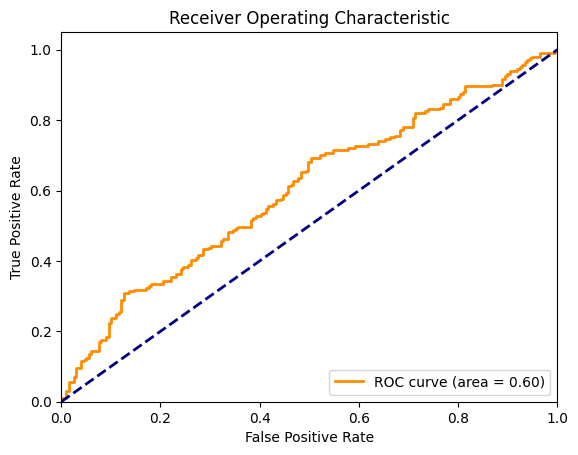

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 원본 데이터와 생성된 데이터 각각에서 1000행만 추출하여 로드
original_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/Adult (2).csv", nrows=1000)
synthetic_data = pd.read_csv("/content/drive/MyDrive/BITamin Final Project - Dacon/adult_output_ctabgan+_0.csv", nrows=1000)

# 라벨 추가 (원본 데이터: 0, 생성된 데이터: 1)
original_data['label'] = 0
synthetic_data['label'] = 1

# 두 데이터셋 결합
combined_data = pd.concat([original_data, synthetic_data], ignore_index=True)

# 범주형 컬럼과 연속형 컬럼 구분
categorical_columns =  ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
numerical_columns = [col for col in combined_data.columns if col not in categorical_columns and col != 'label']

def preprocess_data(df):
    # 범주형 열을 문자열로 변환
    for column in categorical_columns:
        df[column] = df[column].astype(str)

    # 원-핫 인코딩
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_categorical = encoder.fit_transform(df[categorical_columns])

    # 연속형 데이터 스케일링
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(df[numerical_columns])

    # 인코딩된 데이터와 스케일된 데이터 합치기
    X = np.hstack((encoded_categorical, scaled_numerical))
    y = df['label'].values

    return X, y

X, y = preprocess_data(combined_data)

# 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 분류기 학습
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 결과 출력
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC AUC Score: {roc_auc}')

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

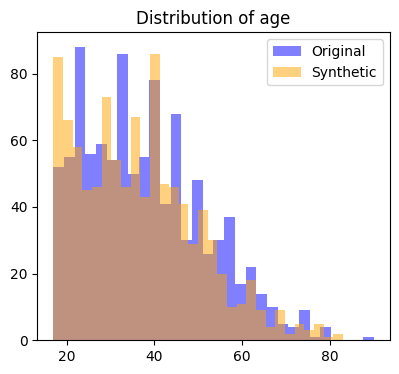

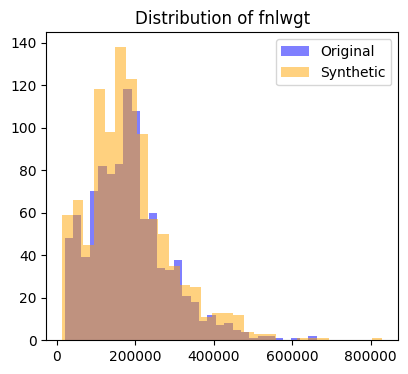

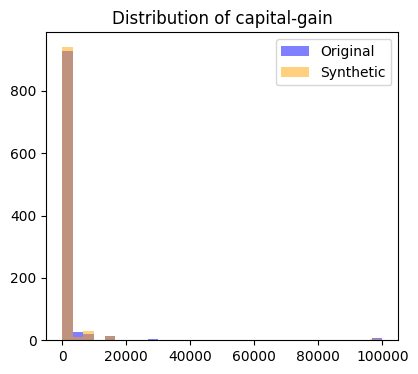

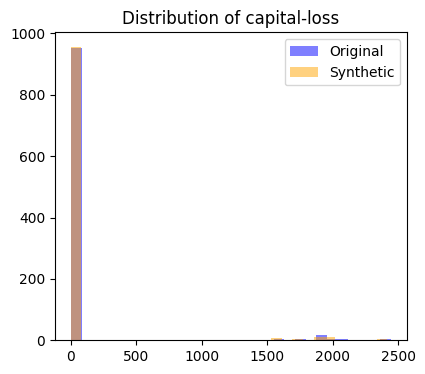

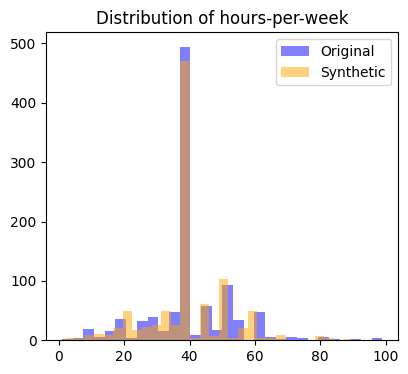

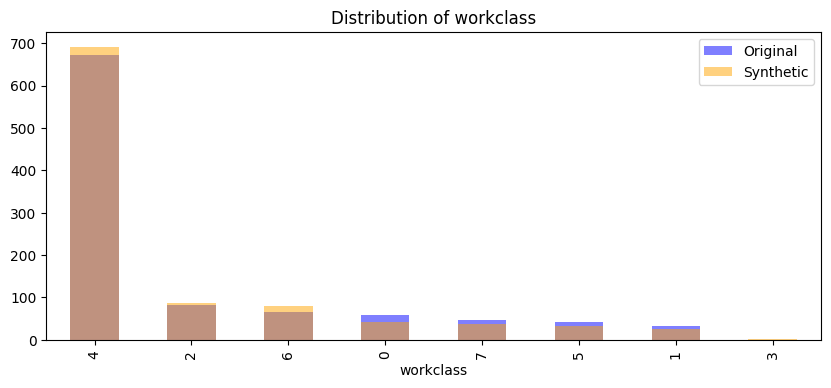

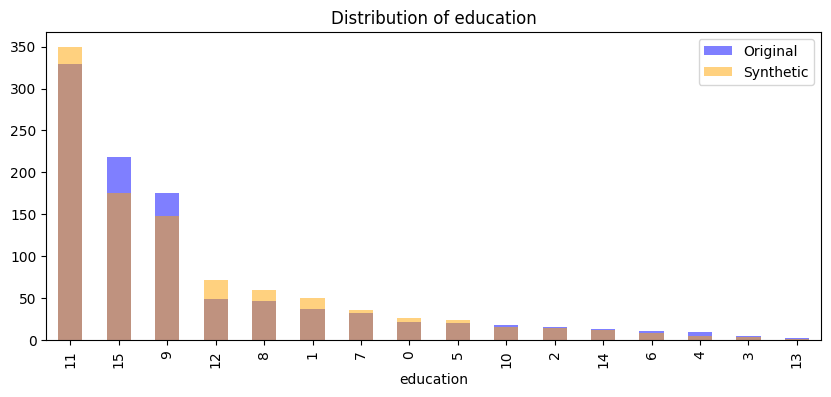

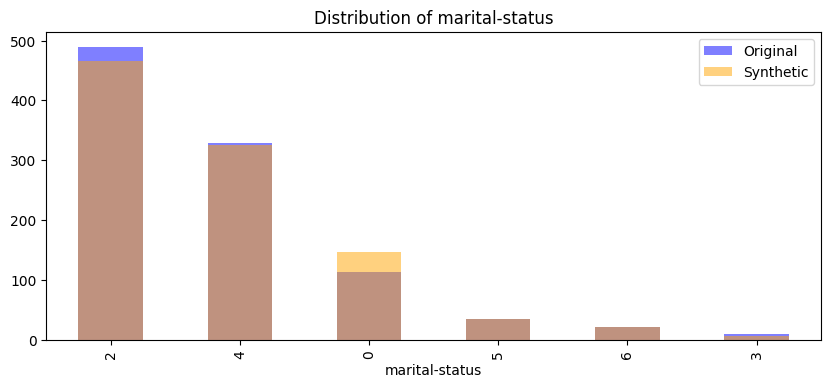

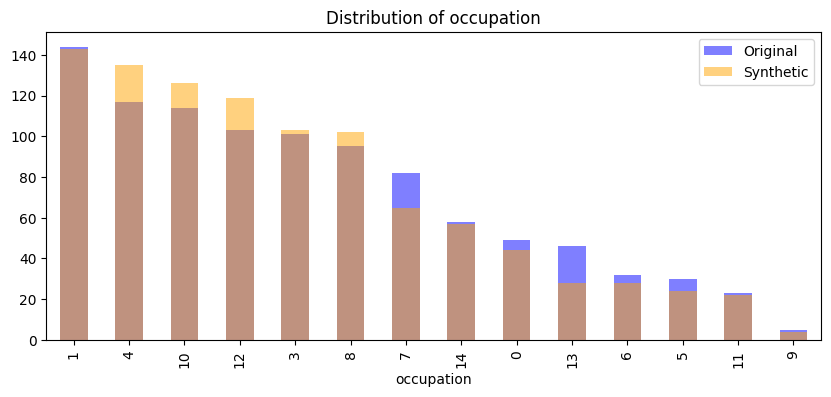

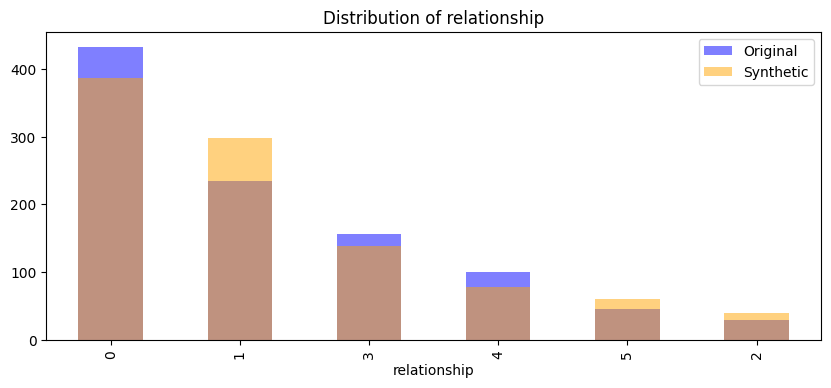

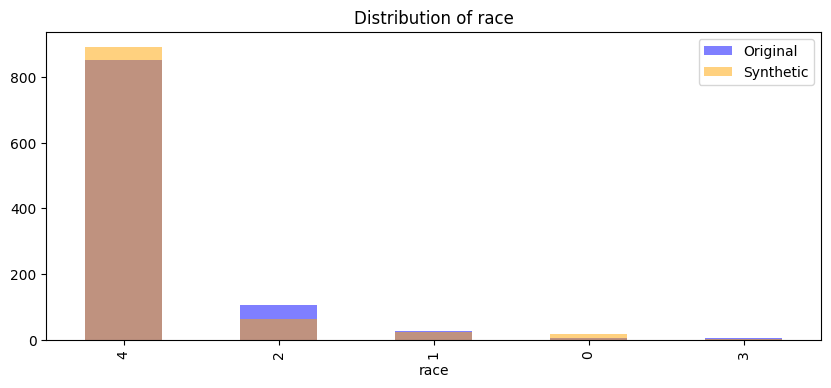

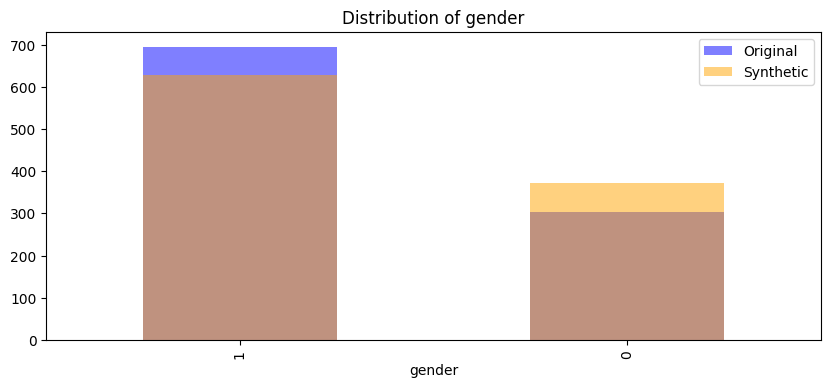

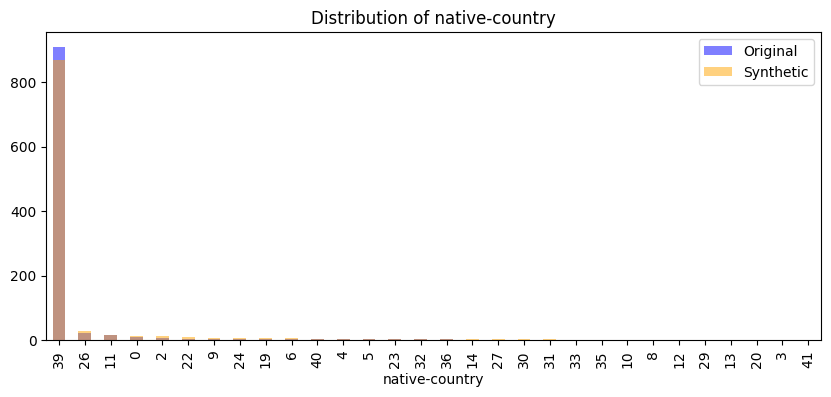

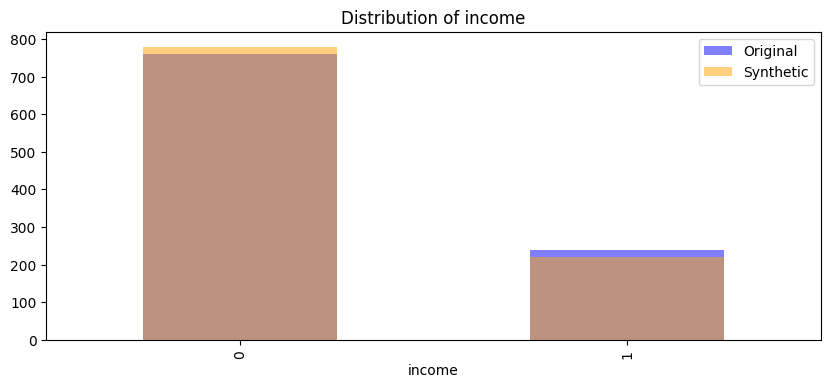

In [ ]:
import matplotlib.pyplot as plt

# 데이터 분포 시각화
def plot_distributions(original, synthetic, columns, kind='hist'):
    for col in columns:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        if kind == 'hist':
            plt.hist(original[col], bins=30, alpha=0.5, label='Original', color='blue')
            plt.hist(synthetic[col], bins=30, alpha=0.5, label='Synthetic', color='orange')
        elif kind == 'box':
            plt.boxplot([original[col], synthetic[col]], labels=['Original', 'Synthetic'])
        plt.title(f'Distribution of {col}')
        plt.legend()
        plt.show()

# 연속형 데이터 분포 시각화
plot_distributions(original_data, synthetic_data, numerical_columns, kind='hist')

# 범주형 데이터 분포 시각화
for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    original_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Original', color='blue')
    synthetic_data[col].value_counts().plot(kind='bar', alpha=0.5, label='Synthetic', color='orange')
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()